## <span style="color:blue">Name:</span> Christian Hellum Bye
## <span style="color:blue">E-mail:</span> chbye@berkeley.edu
## <span style="color:blue">Date:</span> 06-04-22

# HW6: Machine learning

**Due Wednesday April 6, 8pm**

(AY250 2022)

## Galaxy Classification with CNNs

Galaxies appear with different shapes and colors depending on a number of factors, including age, distance, and history of mergers with other galaxies. A crowd-sourced group was [asked to visually classify a set of galaxies from a telescope survey](https://data.galaxyzoo.org/gz_trees/gz_trees.html), resulting in a labelled dataset of 21,785 galaxies across 10 different labels.

You can download it locally:
```bash
curl -o galaxies10.h5 http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
```
Or access it on the shared drive on `astro.datahub.berkeley.edu` at `shared/HW_6/galaxies10.h5`

First, load the data:

In [1]:
!curl -o galaxies10.h5 http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  200M  100  200M    0     0  63.8M      0  0:00:03  0:00:03 --:--:-- 63.8M


In [2]:
import h5py
import numpy as np
from tensorflow.keras import utils

# To get the images and labels from file
with h5py.File('galaxies10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# Convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# Convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)

print(f"labels shape: {labels.shape}")
print(f"images shape: {images.shape}")

labels shape: (21785, 10)
images shape: (21785, 69, 69, 3)


### Visualize and inspect

In a single, multi-panel figure visualize one randomly chosen galaxy from each of the 10 classes. Be sure to set the random seed so that your figure will be reproducible. 

# <span style="color:green">SOLUTION</span>

In [3]:
# convert image brightness from 0-255 to 0-1
images /= 255

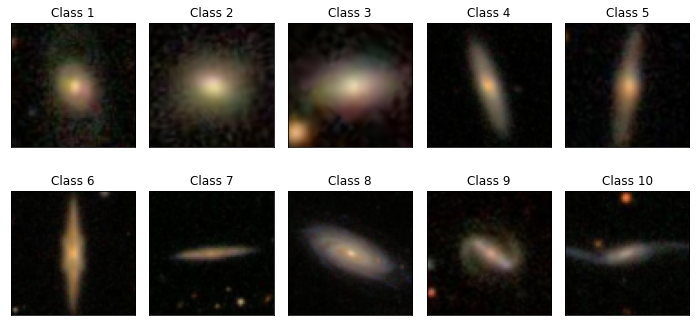

In [4]:
import matplotlib.pyplot as plt
rng = np.random.default_rng(seed=42)

N_labels = labels.shape[-1]
fig, axs = plt.subplots(figsize=(10,5), ncols=N_labels//2, nrows=2, sharex=True, sharey=True)
for i in range(N_labels):
    indx = np.nonzero(labels[:, i])[0]  # galaxies with the given label
    img = rng.choice(images[indx])
    ax = axs[i//(N_labels//2), i%(N_labels//2)]
    ax.imshow(img)
    ax.set_title(f"Class {i+1}")
fig.tight_layout()
plt.setp(axs, xticks=[], yticks=[])
plt.show()

Show a histogram of the distribution of galaxies across classes. Comment on any differences you notice with this dataset and the MNIST.

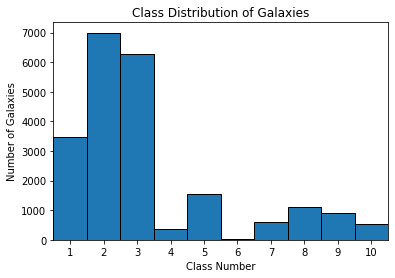

In [ ]:
dist = [len(np.nonzero(labels[:, i])[0]) for i in range(N_labels)]
classes = np.arange(N_labels)+1
plt.figure()
plt.bar(classes, dist, width=1, edgecolor="k")
plt.xlim(0.5, N_labels+0.5)
plt.xticks(classes)
plt.ylabel("Number of Galaxies")
plt.xlabel("Class Number")
plt.title("Class Distribution of Galaxies")
plt.show()

In [ ]:
from tensorflow.keras.datasets import mnist
mnistdata = mnist.load_data()

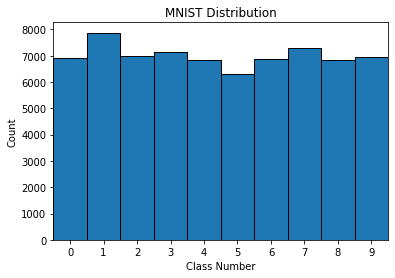

In [ ]:
mnist_labels = np.concatenate((mnistdata[0][1], mnistdata[1][1]))  # conacatenate training and test labels
mnist_classes = np.unique(mnist_labels)
mnist_bins = np.concatenate((mnist_classes - 0.5, [mnist_classes.max()+0.5]))
plt.figure()
mnist_dist,_,_ = plt.hist(mnist_labels, bins=mnist_bins, edgecolor="k")
plt.xlim(mnist_bins.min(), mnist_bins.max())
plt.title("MNIST Distribution")
plt.xlabel("Class Number")
plt.ylabel("Count")
plt.xticks(mnist_classes)
plt.show()

In [ ]:
print("Galaxy class distribution:")
print("Standard deviation relative to dataset size: {:.4f}".format(np.std(dist)/np.sum(dist)))
print("Maximum variation: {:d}".format(np.max(dist)-np.min(dist)))
print("\nMNIST class distribution:")
print("Standard deviation relative to dataset size: {:.4f}".format(np.std(mnist_dist)/np.sum(mnist_dist)))
print("Maximum variation: {:.0f}".format(np.max(mnist_dist)-np.min(mnist_dist)))

Galaxy class distribution:
Standard deviation relative to dataset size: 0.1108
Maximum variation: 6980

MNIST class distribution:
Standard deviation relative to dataset size: 0.0054
Maximum variation: 1564


The galaxy dataset is distributed in an uneven way compared to the MNIST dataset. This is clear visually from the two histograms (in particular there are almost no galaxies in class 4 and 6 compared to class 2), and quantitatively with the standard deviation being 11\% of the dataset size for the galaxy dataset and 0.5\% for the MNIST dataset.

### Prepare for training

First, split the dataset into a train, validation, and test set with a fixed random seed. Then, construct a simple (~few layers) CNN that will accommodate the 69x69x3 images and return a classification. Hint: you will need to modify the networks we built in class to handle the 3d inputs (check out `Conv3D` https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv3D).

# <span style="color:green">SOLUTION</span>

In [5]:
# split dataset
VAL_SIZE, TEST_SIZE = 0.1, 0.15  # fraction of dataset for validation and training
N_imgs = images.shape[0]
im_indx = np.arange(N_imgs)  # list of image indices
rng_split = np.random.default_rng(seed=666)
val_indx = rng_split.choice(im_indx, size=int(VAL_SIZE*N_imgs), replace=False)  # randomly select images for val set
mask = np.ones(N_imgs, dtype=bool)
mask[val_indx] = False
test_indx = rng_split.choice(im_indx[mask], size=int(TEST_SIZE*N_imgs), replace=False)  # test set
mask[test_indx] = False
train_indx = im_indx[mask]  # the images not selected for validation and test go to training

# make sure that we are actually splitting the datasets properly
assert len(train_indx) + len(val_indx) + len(test_indx) == N_imgs
assert set(train_indx).isdisjoint(val_indx)
assert set(train_indx).isdisjoint(test_indx)
assert set(test_indx).isdisjoint(val_indx)

X_train = images[train_indx]
X_val = images[val_indx]
X_test = images[test_indx]
X_train.shape = X_train.shape + (1,)
X_val.shape = X_val.shape + (1,)
X_test.shape = X_test.shape + (1,)

y_train = labels[train_indx]
y_val = labels[val_indx]
y_test = labels[test_indx]

In [6]:
import tensorflow as tf

In [ ]:
#import tensorflow as tf

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv3D(64, (3, 3, 1), activation=tf.keras.activations.relu,
                                 input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 1)))

model.add(tf.keras.layers.Conv3D(32, (3, 3, 1), activation=tf.keras.activations.relu,))
model.add(tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 1)))

model.add(tf.keras.layers.Conv3D(16, (3, 3, 1), activation=tf.keras.activations.relu,))
model.add(tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 1)))


model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(N_labels, activation=tf.keras.activations.softmax))
model.add

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 67, 67, 3, 64)     640       
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 33, 33, 3, 64)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 31, 31, 3, 32)     18464     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 15, 3, 32)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 13, 13, 3, 16)     4624      
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 6, 6, 3, 16)     

### Train

Using early stopping and learning rate decay, train the network you built. Use the validation dataset at the end of each epoch for the early stopping. You might decide to do this part on colab for GPU access.

# <span style="color:green">SOLUTION</span>

In [7]:
# callbacks

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=5e-3,
    patience=10,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.75,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=5e-2,
    cooldown=0,
    min_lr=0,
)

In [8]:
from tqdm.keras import TqdmCallback
BATCH_SIZE = 256

# compile:
LR = 1e-2  # initial learning rate

In [ ]:
from tqdm.keras import TqdmCallback
BATCH_SIZE = 256

# compile:
LR = 1e-2  # initial learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.Accuracy()]
)

# train:
hist = model.fit(
    x=X_train, 
    y=y_train, 
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val), 
    callbacks=[early_stop, lr_schedule, TqdmCallback()],
    verbose=0
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
# # loss
# train_loss = hist.history["loss"]
# val_loss = hist.history["val_loss"]

# # accuracy
# train_acc = hist.history["accuracy"]
# val_acc = hist.history["val_accuracy"]

# model.save("cnn1.h5")
# np.savez("cnn1_loss.npy", train=train_loss, val=val_loss)

In [ ]:
losses = np.load("cnn1_loss.npz")
train_loss = losses["train"]
val_loss = losses["val"]

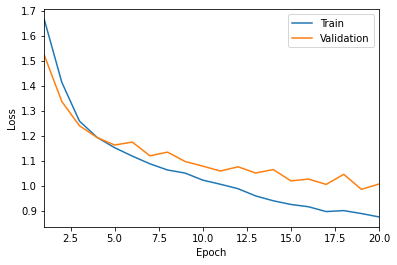

In [ ]:
epochs = np.arange(len(train_loss)) + 1
plt.figure()
plt.plot(epochs, train_loss, label="Train")
plt.plot(epochs, val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xlim(1, epochs.max())
#plt.yscale("log")
plt.show()

### Evaluation

Use your trained model and apply it to the test set. How well did you do (total accuracy)? Plot a confusion matrix and comment where the network was most confused.

# <span style="color:green">SOLUTION</span>

In [ ]:
predicted = tf.one_hot(np.argmax(model.predict(X_test), axis=1), y_test.shape[-1], on_value=1, off_value=0)
acc = tf.keras.metrics.Accuracy()
acc.update_state(y_test, predicted)
print("Accuracy on test set is: {}".format(acc.result()))

Accuracy on test set is: 0.9258646965026855


In [21]:
def confusion_matrix(y_true, y_pred):
    """
    Compute the confusion matrix of a classifer.
    
    Parameters
    -----------
    y_true : np.ndarray
        Set of true labels.
    y_pred : np.ndarray
        Set of predicted labels.
    
    Returns
    -------
    conf_matrix : np.ndarray
        The confusion matrix. It has dimensions N_labels x N_labels (number of labels) where each column is the
        predicted label and each row is the true label.
    
    """
    n_labels = y_true.shape[1]
    conf_matrix = np.zeros((n_labels, n_labels))
    for i in range(n_labels):
        true_idx = np.nonzero(y_true[:, i])[0]
        for idx in true_idx:
            label = np.argmax(predicted[idx])
            conf_matrix[i, label] += 1
    return conf_matrix

In [ ]:
c=confusion_matrix(y_test, predicted.numpy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


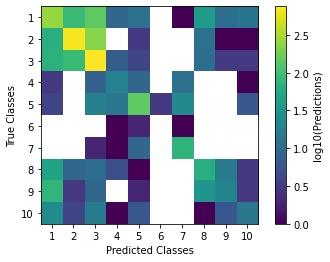

In [ ]:
plt.imshow(np.log10(c), extent=[1, N_labels+1, N_labels+1, 1])
plt.colorbar(label="log10(Predictions)")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
ticks = np.arange(N_labels)+1
labels = [str(t) for t in ticks]
plt.xticks(ticks+.5, labels)
plt.yticks(ticks+.5, labels)
plt.show()

As expected, the network predicted the class labels 2 and 3 too often and 4 and 6 too rarely. This is because the dataset is very unevnly distributed so there's a greater chance to be right when predicting 2 or 3 than when predicting 4 or 6. Additionally, for classes 4 and 6, there is simply very little data to learn features from.

### Improve - data augmentation

Now that you have a baseline accuracy, you can work to try to improve the results. Without changing your network architecture, implement a data augmentation strategy, retrain, and then reevaluate. How much improvement did you see?

# <span style="color:green">SOLUTION</span>

In [13]:
model = tf.keras.models.load_model("cnn1.h5")

In [14]:
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=5,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest",
)

image_generator = image_datagen.flow(
    X_train[:, :, :, :, 0],
    y_train,
    shuffle=True,
    batch_size=BATCH_SIZE,
    seed=42,
)

In [15]:
hist = model.fit(image_generator,
                 epochs=15,
                 validation_data=(X_val, y_val),
                 callbacks=[lr_schedule, early_stop, TqdmCallback()],
                 verbose=0,
        )

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [16]:
# loss
train_loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

# accuracy
train_acc = hist.history["accuracy"]
val_acc = hist.history["val_accuracy"]

model.save("cnn2.h5")
np.savez("cnn2_loss.npy", train=train_loss, val=val_loss)

In [17]:
# losses = np.load("cnn2_loss.npz")
# train_loss = losses["train"]
# val_loss = losses["val"]

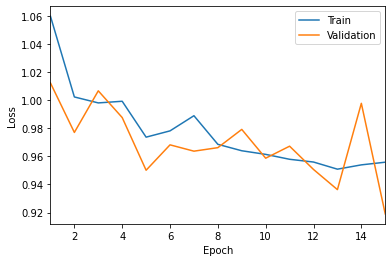

In [18]:
epochs = np.arange(len(train_loss)) + 1
plt.figure()
plt.plot(epochs, train_loss, label="Train")
plt.plot(epochs, val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xlim(1, epochs.max())
#plt.yscale("log")
plt.show()

In [19]:
predicted = tf.one_hot(np.argmax(model.predict(X_test), axis=1), y_test.shape[-1], on_value=1, off_value=0)
acc = tf.keras.metrics.Accuracy()
acc.update_state(y_test, predicted)
print("Accuracy on test set is: {}".format(acc.result()))

Accuracy on test set is: 0.9262320399284363


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


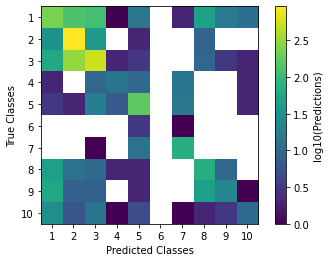

In [22]:
c=confusion_matrix(y_test, predicted.numpy())
plt.imshow(np.log10(c), extent=[1, N_labels+1, N_labels+1, 1])
plt.colorbar(label="log10(Predictions)")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
ticks = np.arange(N_labels)+1
labels = [str(t) for t in ticks]
plt.xticks(ticks+.5, labels)
plt.yticks(ticks+.5, labels)
plt.show()

The accuracy went from 0.9258 to 0.9262 We can also see that the network now was able to predict class 4 better than before, but was still confused about class 6.

### Improve - network

Change/embellish your original network to try to improve the results (try adding layers, changing the initialization of the kernel weights, changing the activation, adding dropout). You can use an automl trainer if you'd like or try different approaches by hand. Retrain and then reevaluate. Explain what you did but only show us the best model and its evaluation.

In [ ]:
# define improved model
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv3D(32, (3, 3, 1), activation=tf.keras.activations.relu,
                                 input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.MaxPooling3D(pool_size=(5, 2, 1)))

model.add(tf.keras.layers.Conv3D(16, (3, 3, 1), activation=tf.keras.activations.relu,))
model.add(tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 1)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(N_labels, activation=tf.keras.activations.softmax))

model.summary()

# compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.Accuracy()]
)

# train:
hist = model.fit(
    x=X_train, 
    y=y_train, 
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val), 
    callbacks=[early_stop, lr_schedule, TqdmCallback()],
    verbose=0
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 67, 67, 3, 32)     320       
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 13, 33, 3, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 11, 31, 3, 16)     4624      
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 5, 15, 3, 16)     0         
 g3D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 3600)              0         
                                                                 
 dense_5 (Dense)             (None, 10)               

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
# # loss
# train_loss = hist.history["loss"]
# val_loss = hist.history["val_loss"]

# # accuracy
# train_acc = hist.history["accuracy"]
# val_acc = hist.history["val_accuracy"]

# model.save("cnn3.h5")
# np.savez("cnn3_loss.npy", train=train_loss, val=val_loss)

In [ ]:
losses = np.load("cnn3_loss.npz")
train_loss = losses["train"]
val_loss = losses["val"]

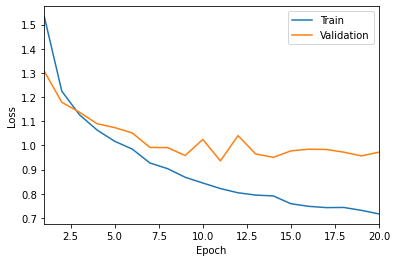

In [ ]:
epochs = np.arange(len(train_loss)) + 1
plt.figure()
plt.plot(epochs, train_loss, label="Train")
plt.plot(epochs, val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xlim(1, epochs.max())
#plt.yscale("log")
plt.show()

In [ ]:
predicted = tf.one_hot(np.argmax(model.predict(X_test), axis=1), y_test.shape[-1], on_value=1, off_value=0)
acc = tf.keras.metrics.Accuracy()
acc.update_state(y_test, predicted)
print("Accuracy on test set is: {}".format(acc.result()))

Accuracy on test set is: 0.9328435659408569


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


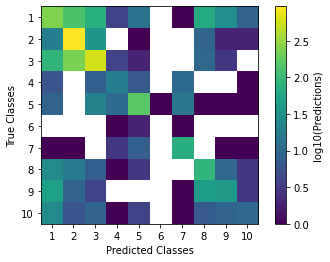

In [ ]:
c=confusion_matrix(y_test, predicted.numpy())
plt.imshow(np.log10(c), extent=[1, N_labels+1, N_labels+1, 1])
plt.colorbar(label="log10(Predictions)")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
ticks = np.arange(N_labels)+1
labels = [str(t) for t in ticks]
plt.xticks(ticks+.5, labels)
plt.yticks(ticks+.5, labels)
plt.show()

I tried varying the number of layer and their dimensionalities. I also started playing around with the max pooling. It turned out that the simpler network (with more pooling) shown above performs better than the original network: the accuracy went from 0.926 to 0.933.

## Autoencoders

A form of non-parametric representation learning with neutral nets, where the architecture of the network is used to reduce the dimensionality of the data. First, go through (and execute) the following codeblocks and make sure you understand what they are doing to build and use an autoencoder.

As the name suggests, autoencoders uses the data itself to learn the best way to represent it in a compact way--it's a form of semantic compression. This is a family of self- (or un-) supervised modeling.

<img src="https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png">
Source: https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

In practice, we take an input X (which may be a 1-d vector, 2-d image, ...) and try to squeeze it down to a smaller number of values in the "bottleneck" layer and then uncompress back to it's original shape and form. The loss function that we construct will be the way in which the network learns on each backprop through the data.

Let's look at a autoencoder which uses convnets to restruct the fashion dataset.

In [ ]:
import datetime, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow 
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, \
                                    Activation, BatchNormalization, UpSampling2D
from tensorflow.keras import backend as K
import tensorflow as tf

# Print keras version
print(tensorflow.keras.__version__)

from tensorflow.keras.utils import to_categorical

fashion_mnist = tf.keras.datasets.fashion_mnist

nb_classes = 10
batch_size = 128
bottleneck_size = 64

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # scale the images to 0-1

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

# convert class vectors to binary class matrices
Y_train =  to_categorical(y_train, nb_classes)
Y_test =  to_categorical(y_test, nb_classes)

input_shape = x_train[0].shape  + (1,)
input_shape
input_img = Input(shape = (28, 28, 1))

2.8.0
4431872/4422102 [==============================] - 0s 0us/step


Make a simple autoencoder

In [ ]:
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Flatten()(x)
bottleneck = Dense(bottleneck_size, name="bottleneck")(x)

x = Dense(128)(bottleneck)
x = Reshape((4, 4, 8))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# add with tf.device('/gpu:0'): if on GPU
autoencoder = Model(input_img, decoded)


logdir = os.path.join(
    "nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

model_path = f'nn_results/ay250_autoencoder_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")


model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
                                                 monitor='val_loss',
                                                 save_best_only=True,
                                                 mode='min',
                                                 verbose=1)

tensorboard_callback = \
    tensorflow.keras.callbacks.TensorBoard(logdir,
                                           histogram_freq=0,
                                           write_graph=True,
                                           write_grads=False,
                                           write_images=False,
                                           embeddings_freq=0,
                                           embeddings_layer_names=None,
                                           embeddings_metadata=None, embeddings_data=None)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder_train = autoencoder.fit(x_train, x_train,
                                    batch_size=batch_size, epochs=10,
                                    verbose=1, shuffle=False,
                                    validation_data=(x_test, x_test),
                                    callbacks=[tensorboard_callback, model_check])

Training ... nn_results/ay250_autoencoder_nn_2022-04-07T03:16.h5
Epoch 1/10
469/469 [==============================] - ETA: 0s - loss: 0.0385
Epoch 1: val_loss improved from inf to 0.02600, saving model to nn_results/ay250_autoencoder_nn_2022-04-07T03:16.h5
469/469 [==============================] - 5s 8ms/step - loss: 0.0385 - val_loss: 0.0260
Epoch 2/10
464/469 [============================>.] - ETA: 0s - loss: 0.0223
Epoch 2: val_loss improved from 0.02600 to 0.02033, saving model to nn_results/ay250_autoencoder_nn_2022-04-07T03:16.h5
469/469 [==============================] - 3s 7ms/step - loss: 0.0223 - val_loss: 0.0203
Epoch 3/10
460/469 [============================>.] - ETA: 0s - loss: 0.0197
Epoch 3: val_loss improved from 0.02033 to 0.01852, saving model to nn_results/ay250_autoencoder_nn_2022-04-07T03:16.h5
469/469 [==============================] - 3s 6ms/step - loss: 0.0196 - val_loss: 0.0185
Epoch 4/10
466/469 [============================>.] - ETA: 0s - loss: 0.0182
Epoc

In [ ]:
from tensorflow.keras.models import load_model
latest_model_file = !ls -t1 nn_results/ay250_*.h5 | head -1
latest_model_file = latest_model_file[0]
print(f"Using {latest_model_file}")
autoencoder = load_model(latest_model_file)

Using nn_results/ay250_autoencoder_nn_2022-04-07T03:16.h5


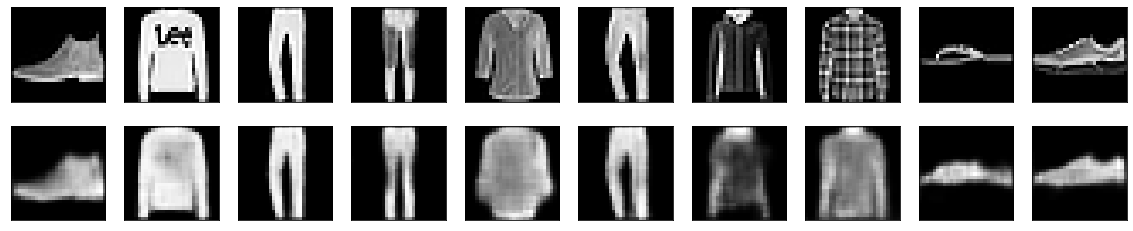

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Classify using Random Forest

Using the autoencoder model above, create a random forest model to predict the classes of the images using the 64-parameter bottleneck layer. What accuracy do you get? How does it compare with the accuracy we got on the `convnet` model before?

# <span style="color:green">SOLUTION</span>

In [ ]:
encoder = Model(inputs=autoencoder.input,
                                 outputs=autoencoder.get_layer("bottleneck").output)
latent_train = encoder.predict(x_train)
latent_test = encoder.predict(x_test)


from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(latent_train, Y_train)
# make predictions for testing set
rf_img = clf.predict(latent_test) 


# compute zero-one loss / score & confusion matrix
from sklearn import metrics

rf_01 = metrics.zero_one_loss(Y_test, rf_img) # zero-one loss
rf_01_score = metrics.accuracy_score(Y_test, rf_img) # zero-one score
#rf_confmat = confusion_matrix(Y_test, rf_img) # conf mat

print("Zero-One Loss: " + str(rf_01))
print("Zero-One Score: " + str(rf_01_score))
print("Confusion Matrix:")
print("[i, j] is the # of objects truly in group i but predicted to be in group j")
#plt.imshow(rf_confmat)



Zero-One Loss: 0.21940000000000004
Zero-One Score: 0.7806
Confusion Matrix:
[i, j] is the # of objects truly in group i but predicted to be in group j


In [ ]:
acc = tf.keras.metrics.Accuracy()
acc.update_state(Y_test, rf_img)
print("Accuracy on test set is: {}".format(acc.result()))

Accuracy on test set is: 0.9709200263023376


In [ ]:
import joblib
joblib.dump(clf, "./random_forest.joblib")

['./random_forest.joblib']

I got an accuracy of 0.971, which is a significant improvement from the convnet model from class that had an accuracy of ..

### Bottleneck size variation

Experiment with trying a different sized layer (e.g., size 4, 16, 32) and repeat step a) above. Do you see any trends with bottleneck size?

# <span style="color:green">SOLUTION (size=4)</span>

In [ ]:
bottleneck_size = 4

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Flatten()(x)
bottleneck = Dense(bottleneck_size, name="bottleneck")(x)

x = Dense(128)(bottleneck)
x = Reshape((4, 4, 8))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# add with tf.device('/gpu:0'): if on GPU
autoencoder = Model(input_img, decoded)


logdir = os.path.join(
    "nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

model_path = f'nn_results/ay250_autoencoder_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")


model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
                                                 monitor='val_loss',
                                                 save_best_only=True,
                                                 mode='min',
                                                 verbose=1)

tensorboard_callback = \
    tensorflow.keras.callbacks.TensorBoard(logdir,
                                           histogram_freq=0,
                                           write_graph=True,
                                           write_grads=False,
                                           write_images=False,
                                           embeddings_freq=0,
                                           embeddings_layer_names=None,
                                           embeddings_metadata=None, embeddings_data=None)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder_train = autoencoder.fit(x_train, x_train,
                                    batch_size=batch_size, epochs=10,
                                    verbose=1, shuffle=False,
                                    validation_data=(x_test, x_test),
                                    callbacks=[tensorboard_callback, model_check])

latest_model_file = !ls -t1 nn_results/ay250_*.h5 | head -1
latest_model_file = latest_model_file[0]
print(f"Using {latest_model_file}")
autoencoder = load_model(latest_model_file)


encoder = Model(inputs=autoencoder.input,
                                 outputs=autoencoder.get_layer("bottleneck").output)
latent_train = encoder.predict(x_train)
latent_test = encoder.predict(x_test)


from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(latent_train, Y_train)
# make predictions for testing set
rf_img = clf.predict(latent_test) 


# compute zero-one loss / score & confusion matrix
from sklearn import metrics

rf_01 = metrics.zero_one_loss(Y_test, rf_img) # zero-one loss
rf_01_score = metrics.accuracy_score(Y_test, rf_img) # zero-one score
#rf_confmat = confusion_matrix(Y_test, rf_img) # conf mat

print("Zero-One Loss: " + str(rf_01))
print("Zero-One Score: " + str(rf_01_score))
print("Confusion Matrix:")
print("[i, j] is the # of objects truly in group i but predicted to be in group j")
#plt.imshow(rf_confmat)

acc = tf.keras.metrics.Accuracy()
acc.update_state(Y_test, rf_img)
print("Accuracy on test set is: {}".format(acc.result()))

import joblib
joblib.dump(clf, f"./random_forest_{bottleneck_size}.joblib")

Training ... nn_results/ay250_autoencoder_nn_2022-04-07T03:29.h5
Epoch 1/10
463/469 [============================>.] - ETA: 0s - loss: 0.0483
Epoch 1: val_loss improved from inf to 0.03225, saving model to nn_results/ay250_autoencoder_nn_2022-04-07T03:29.h5
469/469 [==============================] - 6s 10ms/step - loss: 0.0481 - val_loss: 0.0323
Epoch 2/10
468/469 [============================>.] - ETA: 0s - loss: 0.0300
Epoch 2: val_loss improved from 0.03225 to 0.02810, saving model to nn_results/ay250_autoencoder_nn_2022-04-07T03:29.h5
469/469 [==============================] - 3s 7ms/step - loss: 0.0300 - val_loss: 0.0281
Epoch 3/10
467/469 [============================>.] - ETA: 0s - loss: 0.0278
Epoch 3: val_loss improved from 0.02810 to 0.02661, saving model to nn_results/ay250_autoencoder_nn_2022-04-07T03:29.h5
469/469 [==============================] - 4s 9ms/step - loss: 0.0278 - val_loss: 0.0266
Epoch 4/10
465/469 [============================>.] - ETA: 0s - loss: 0.0266
Epo

['./random_forest_4.joblib']

# <span style="color:green">SOLUTION (size=16)</span>

In [ ]:
bottleneck_size = 16

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Flatten()(x)
bottleneck = Dense(bottleneck_size, name="bottleneck")(x)

x = Dense(128)(bottleneck)
x = Reshape((4, 4, 8))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# add with tf.device('/gpu:0'): if on GPU
autoencoder = Model(input_img, decoded)


logdir = os.path.join(
    "nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

model_path = f'nn_results/ay250_autoencoder_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")


model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
                                                 monitor='val_loss',
                                                 save_best_only=True,
                                                 mode='min',
                                                 verbose=1)

tensorboard_callback = \
    tensorflow.keras.callbacks.TensorBoard(logdir,
                                           histogram_freq=0,
                                           write_graph=True,
                                           write_grads=False,
                                           write_images=False,
                                           embeddings_freq=0,
                                           embeddings_layer_names=None,
                                           embeddings_metadata=None, embeddings_data=None)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder_train = autoencoder.fit(x_train, x_train,
                                    batch_size=batch_size, epochs=10,
                                    verbose=1, shuffle=False,
                                    validation_data=(x_test, x_test),
                                    callbacks=[tensorboard_callback, model_check])

latest_model_file = !ls -t1 nn_results/ay250_*.h5 | head -1
latest_model_file = latest_model_file[0]
print(f"Using {latest_model_file}")
autoencoder = load_model(latest_model_file)


encoder = Model(inputs=autoencoder.input,
                                 outputs=autoencoder.get_layer("bottleneck").output)
latent_train = encoder.predict(x_train)
latent_test = encoder.predict(x_test)


from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(latent_train, Y_train)
# make predictions for testing set
rf_img = clf.predict(latent_test) 


# compute zero-one loss / score & confusion matrix
from sklearn import metrics

rf_01 = metrics.zero_one_loss(Y_test, rf_img) # zero-one loss
rf_01_score = metrics.accuracy_score(Y_test, rf_img) # zero-one score
#rf_confmat = confusion_matrix(Y_test, rf_img) # conf mat

print("Zero-One Loss: " + str(rf_01))
print("Zero-One Score: " + str(rf_01_score))
print("Confusion Matrix:")
print("[i, j] is the # of objects truly in group i but predicted to be in group j")
#plt.imshow(rf_confmat)

acc = tf.keras.metrics.Accuracy()
acc.update_state(Y_test, rf_img)
print("Accuracy on test set is: {}".format(acc.result()))

import joblib
joblib.dump(clf, f"./random_forest_{bottleneck_size}.joblib")

Training ... nn_results/ay250_autoencoder_nn_2022-04-07T03:30.h5
Epoch 1/10
468/469 [============================>.] - ETA: 0s - loss: 0.0383
Epoch 1: val_loss improved from inf to 0.02858, saving model to nn_results/ay250_autoencoder_nn_2022-04-07T03:30.h5
469/469 [==============================] - 4s 7ms/step - loss: 0.0382 - val_loss: 0.0286
Epoch 2/10
464/469 [============================>.] - ETA: 0s - loss: 0.0236
Epoch 2: val_loss improved from 0.02858 to 0.02180, saving model to nn_results/ay250_autoencoder_nn_2022-04-07T03:30.h5
469/469 [==============================] - 3s 7ms/step - loss: 0.0236 - val_loss: 0.0218
Epoch 3/10
466/469 [============================>.] - ETA: 0s - loss: 0.0212
Epoch 3: val_loss improved from 0.02180 to 0.02009, saving model to nn_results/ay250_autoencoder_nn_2022-04-07T03:30.h5
469/469 [==============================] - 3s 7ms/step - loss: 0.0212 - val_loss: 0.0201
Epoch 4/10
465/469 [============================>.] - ETA: 0s - loss: 0.0199
Epoc

['./random_forest_16.joblib']

# <span style="color:green">SOLUTION (size=32)</span>

In [ ]:
bottleneck_size = 32

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Flatten()(x)
bottleneck = Dense(bottleneck_size, name="bottleneck")(x)

x = Dense(128)(bottleneck)
x = Reshape((4, 4, 8))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# add with tf.device('/gpu:0'): if on GPU
autoencoder = Model(input_img, decoded)


logdir = os.path.join(
    "nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

model_path = f'nn_results/ay250_autoencoder_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")


model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
                                                 monitor='val_loss',
                                                 save_best_only=True,
                                                 mode='min',
                                                 verbose=1)

tensorboard_callback = \
    tensorflow.keras.callbacks.TensorBoard(logdir,
                                           histogram_freq=0,
                                           write_graph=True,
                                           write_grads=False,
                                           write_images=False,
                                           embeddings_freq=0,
                                           embeddings_layer_names=None,
                                           embeddings_metadata=None, embeddings_data=None)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder_train = autoencoder.fit(x_train, x_train,
                                    batch_size=batch_size, epochs=10,
                                    verbose=1, shuffle=False,
                                    validation_data=(x_test, x_test),
                                    callbacks=[tensorboard_callback, model_check])

latest_model_file = !ls -t1 nn_results/ay250_*.h5 | head -1
latest_model_file = latest_model_file[0]
print(f"Using {latest_model_file}")
autoencoder = load_model(latest_model_file)


encoder = Model(inputs=autoencoder.input,
                                 outputs=autoencoder.get_layer("bottleneck").output)
latent_train = encoder.predict(x_train)
latent_test = encoder.predict(x_test)


from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(latent_train, Y_train)
# make predictions for testing set
rf_img = clf.predict(latent_test) 


# compute zero-one loss / score & confusion matrix
from sklearn import metrics

rf_01 = metrics.zero_one_loss(Y_test, rf_img) # zero-one loss
rf_01_score = metrics.accuracy_score(Y_test, rf_img) # zero-one score
#rf_confmat = confusion_matrix(Y_test, rf_img) # conf mat

print("Zero-One Loss: " + str(rf_01))
print("Zero-One Score: " + str(rf_01_score))
print("Confusion Matrix:")
print("[i, j] is the # of objects truly in group i but predicted to be in group j")
#plt.imshow(rf_confmat)

acc = tf.keras.metrics.Accuracy()
acc.update_state(Y_test, rf_img)
print("Accuracy on test set is: {}".format(acc.result()))

import joblib
joblib.dump(clf, f"./random_forest_{bottleneck_size}.joblib")

Training ... nn_results/ay250_autoencoder_nn_2022-04-07T03:32.h5
Epoch 1/10
469/469 [==============================] - ETA: 0s - loss: 0.0368
Epoch 1: val_loss improved from inf to 0.02782, saving model to nn_results/ay250_autoencoder_nn_2022-04-07T03:32.h5
469/469 [==============================] - 4s 7ms/step - loss: 0.0368 - val_loss: 0.0278
Epoch 2/10
463/469 [============================>.] - ETA: 0s - loss: 0.0225
Epoch 2: val_loss improved from 0.02782 to 0.02103, saving model to nn_results/ay250_autoencoder_nn_2022-04-07T03:32.h5
469/469 [==============================] - 3s 7ms/step - loss: 0.0225 - val_loss: 0.0210
Epoch 3/10
463/469 [============================>.] - ETA: 0s - loss: 0.0203
Epoch 3: val_loss improved from 0.02103 to 0.01938, saving model to nn_results/ay250_autoencoder_nn_2022-04-07T03:32.h5
469/469 [==============================] - 3s 7ms/step - loss: 0.0203 - val_loss: 0.0194
Epoch 4/10
467/469 [============================>.] - ETA: 0s - loss: 0.0191
Epoc

['./random_forest_32.joblib']

# <span style="color:green">SOLUTION (summary)</span>

We see that the accuracy increases with the bottleneck size: it is best for 64 (the original model), then 32, then 16 and worst for 4.